#Demo NeuroEvolution usando Tensorflow-Neuroevolution framework (TFNE) para generar una RNA MLP que pueda aprender a clasificar (atributo clase discreto) o estimar (atributo clase continuo)

Fuente TFNE: https://github.com/PaulPauls/Tensorflow-Neuroevolution


- Nota 1: si se cambia el tipo de problema ( Clasificación / Estimación ) se recomienda reiniciar el entorno para evitar errores.

- Nota 2: con muchos datos se recomienda ejecutar con GPU para hacer la ejecución más rápido pero pueden producirse errores de sesión por falta de memoria RAM si son demasiados.


In [1]:
#@title Instalar TFNE
!pip install tfne

###!git clone https://github.com/PaulPauls/Tensorflow-Neuroevolution
###%cd Tensorflow-Neuroevolution
###!pip install -r requirements.txt

In [2]:
#@title Librerías a usar
from __future__ import annotations
from absl import app, flags, logging

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

import os
import csv

import tfne
from tfne.environments import BaseEnvironment
from tfne.helper_functions import read_option_from_config

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random
import math

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [3]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [5]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [6]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de CLASIFICACIÓN 

> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 38
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 37

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 12
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 13


# Modelo:

In [7]:
#@title Crear Archivo Configuración de Parámetros para TFNE
# ver explicación en https://tfne.readthedocs.io/en/latest/codeepneat/codeepneat-config.html

#@markdown Criterio de Paro:
ce_maximo_generaciones_procesar = 3 #@param {type:"integer"}
ce_finalizar_al_encontrar_max_fitness = True #@param {type:"boolean"}
#@markdown Función de Aptitud:
fitness_calc_usando = "Entrenamiento + Validacion" #@param ["Entrenamiento", "Validacion", "Entrenamiento + Validacion"]
fitness_penalizar_x_topologia = False #@param {type:"boolean"}
#@markdown Blueprints (topología & optimizador):
ce_cant_poblacion_blueprints =  5#@param {type:"integer"}
#@markdown  Genomas (instancias de RNAs):
ce_cant_genomas_por_blueprint =  4#@param {type:"integer"}
#@markdown Módulos (capas RNA):
ce_cant_poblacion_modulos = 25 #@param {type:"integer"}
ce_tipo_generacion_modulos = "Dinamica" #@param ["Basica", "Dinamica", "Fija"]
#@markdown Operadores Genéticos:
ce_max_mutacion = 0.8 #@param {type:"number"}
ce_probab_mutacion = 0.5 #@param {type:"number"}
ce_probab_cruzamiento = 0.5 #@param {type:"number"}
#@markdown Entrenamiento RNA:
rna_cant_epocas_entrenamiento = 50#@param {type:"integer"}
rna_cant_epocas_entrenamiento_incrementa_por_generacion = 25#@param {type:"integer"}


confFileName = './codeepneat_config.cfg'

s = ""
with open(confFileName, 'w') as f:
    s = s + "[EVALUATION]\n"
    s = s + "epochs        = " + str(rna_cant_epocas_entrenamiento) + "\n"
    s = s + "batch_size    = None\n"
    s = s + "preprocessing = None\n"
    if rna_cant_epocas_entrenamiento_incrementa_por_generacion > 0:
      s = s + "increase_epochs_every_n_genomes = " + str(ce_cant_poblacion_blueprints*ce_cant_genomas_por_blueprint) + "\n"
      s = s + "increase_epochs_add_epochs = " + str(rna_cant_epocas_entrenamiento_incrementa_por_generacion) + "\n"
    else:
      s = s + "increase_epochs_every_n_genomes = 0\n"
      s = s + "increase_epochs_add_epochs = 0\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[FITNESS]\n"
    if fitness_calc_usando == "Entrenamiento":
      s = s + "calc_using_accuracy  = 'E'\n"
    elif fitness_calc_usando == "Validacion":
      s = s + "calc_using_accuracy = 'V'\n"
    else:
      s = s + "calc_using_accuracy = 'E+V'\n"
    s = s + "penalize_based_on_topology  = " + str(fitness_penalizar_x_topologia) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[POPULATION]\n"
    s = s + "bp_pop_size    = " + str(ce_cant_poblacion_blueprints) + "\n"
    s = s + "mod_pop_size   = " + str(ce_cant_poblacion_modulos) + "\n"
    s = s + "genomes_per_bp = " + str(ce_cant_genomas_por_blueprint ) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[GENOME]\n"
    s = s + "dtype                = 'float32'\n"
    s = s + "available_modules    = ['DenseDropout']\n"
    s = s + "available_optimizers = ['SGD','Adam']\n"
    if esProblemaClasificacion:
      # para problema de Clasificación usa salida softmax
      tipo_output_softMax = True
      s = s + "output_layers        = [{'class_name': 'Dense', 'config': {'units': "+ str(len(CLASES)) + ", 'activation': 'softmax'}}] \n"
    else:
      # para problema de Estimación usa salida lineal
      tipo_output_softMax = False
      s = s + "output_layers        = [{'class_name': 'Dense', 'config': {'units': 1, 'activation': None}}] \n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "mod_spec_type            = 'param-distance-dynamic'\n"
      s = s + "mod_spec_species_count   = 4\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 10\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "mod_spec_type            = 'param-distance-fixed'\n"
      s = s + "mod_spec_distance        = 0.3\n"
      s = s + "mod_spec_mod_elitism     = 2\n"
      s = s + "mod_spec_min_offspring   = 1\n"
      s = s + "mod_spec_reprod_thres    = 0.5\n"
      s = s + "mod_spec_max_stagnation  = 10\n"
      s = s + "mod_spec_species_elitism = 2\n"
      s = s + "mod_spec_rebase_repr     = True\n"
      s = s + "mod_spec_reinit_extinct  = False\n"
    else:
      # Basica
      s = s + "mod_spec_type          = 'basic'\n"
      s = s + "mod_spec_mod_elitism   = 4\n"
      s = s + "mod_spec_min_offspring = 1\n"
      s = s + "mod_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_EVOLUTION]\n"
    s = s + "mod_max_mutation   = " + str(ce_max_mutacion) + "\n"
    s = s + "mod_mutation_prob  = " + str(ce_probab_mutacion) + "\n"
    s = s + "mod_crossover_prob = " + str(ce_probab_cruzamiento) + "\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_SPECIATION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_spec_type            = 'gene-overlap-dynamic'\n"
      s = s + "bp_spec_species_count   = 3\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    elif ce_tipo_generacion_modulos == "Fija":
      # Fija
      s = s + "bp_spec_type            = 'gene-overlap-fixed'\n"
      s = s + "bp_spec_distance        = 0.3\n"
      s = s + "bp_spec_bp_elitism      = 2\n"
      s = s + "bp_spec_min_offspring   = 1\n"
      s = s + "bp_spec_reprod_thres    = 0.5\n"
      s = s + "bp_spec_max_stagnation  = 15\n"
      s = s + "bp_spec_species_elitism = 2\n"
      s = s + "bp_spec_rebase_repr     = True\n"
      s = s + "bp_spec_reinit_extinct  = True\n"
    else:
      # Basica
      s = s + "bp_spec_type          = 'basic'\n"
      s = s + "bp_spec_bp_elitism    = 2\n"
      s = s + "bp_spec_min_offspring = 1\n"
      s = s + "bp_spec_reprod_thres  = 0.5\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[BP_EVOLUTION]\n"
    if ce_tipo_generacion_modulos == "Dinamica":
      # Dinamica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.2\n"
      s = s + "bp_mutation_add_node_prob  = 0.2\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.3\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
    else:
      # Fija o Basica
      s = s + "bp_max_mutation            = 0.3\n"
      s = s + "bp_mutation_add_conn_prob  = 0.3\n"
      s = s + "bp_mutation_add_node_prob  = 0.3\n"
      s = s + "bp_mutation_rem_conn_prob  = 0.05\n"
      s = s + "bp_mutation_rem_node_prob  = 0.05\n"
      s = s + "bp_mutation_node_spec_prob = 0.1\n"
      s = s + "bp_mutation_optimizer_prob = 0.1\n"
      s = s + "bp_crossover_prob          = 0.1\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[MODULE_DENSEDROPOUT]\n"
    s = s + "merge_method = [{'class_name': 'Concatenate', 'config': {'axis': -1}}]\n"
    s = s + "units        = {'min': 2, 'max': 100, 'step': 4, 'stddev': 6}\n"
    s = s + "activation   = ['linear', 'relu', 'sigmoid', 'softmax', 'tanh']\n"
    s = s + "kernel_init  = ['glorot_normal', 'he_normal']\n"
    s = s + "bias_init    = ['zeros']\n"
    s = s + "dropout_flag = 0.5\n"
    s = s + "dropout_rate = {'min': 0.1, 'max': 0.4, 'step': 0.1, 'stddev': 0.1}\n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_SGD]\n"
    s = s + "learning_rate = {'min': 0.1, 'max': 0.3, 'step': 0.05, 'stddev': 0.05}\n"
    s = s + "momentum      = {'min': 0.3, 'max': 0.7, 'step': 0.1, 'stddev': 0.1}\n"
    s = s + "nesterov      = [True, False] \n"
    s = s + "\n"
    s = s + "\n"
    s = s + "[OPTIMIZER_ADAM]\n"
    s = s + "learning_rate = {'min': 0.0001, 'max': 0.1, 'step': 0.0001, 'stddev': 0.02}\n"
    s = s + "beta_1        = {'min': 0.6, 'max': 1.5, 'step': 0.05, 'stddev': 0.2}\n"
    s = s + "beta_2        = {'min': 0.8, 'max': 1.2, 'step': 0.001, 'stddev': 0.1}\n"
    s = s + "epsilon       = {'min': 1e-8, 'max': 1e-6, 'step': 1e-8, 'stddev': 1e-7}\n"
    s = s + "\n"
    s = s + "\n"

    f.write(s)

# muestra nuevo archivo modificado
%cat {confFileName}

[EVALUATION]
epochs        = 50
batch_size    = None
preprocessing = None
increase_epochs_every_n_genomes = 20
increase_epochs_add_epochs = 25


[FITNESS]
calc_using_accuracy = 'E+V'
penalize_based_on_topology  = False


[POPULATION]
bp_pop_size    = 5
mod_pop_size   = 25
genomes_per_bp = 4


[GENOME]
dtype                = 'float32'
available_modules    = ['DenseDropout']
available_optimizers = ['SGD','Adam']
output_layers        = [{'class_name': 'Dense', 'config': {'units': 4, 'activation': 'softmax'}}] 


[MODULE_SPECIATION]
mod_spec_type            = 'param-distance-dynamic'
mod_spec_species_count   = 4
mod_spec_distance        = 0.3
mod_spec_mod_elitism     = 2
mod_spec_min_offspring   = 1
mod_spec_reprod_thres    = 0.5
mod_spec_max_stagnation  = 10
mod_spec_species_elitism = 2
mod_spec_rebase_repr     = True
mod_spec_reinit_extinct  = False


[MODULE_EVOLUTION]
mod_max_mutation   = 0.8
mod_mutation_prob  = 0.5
mod_crossover_prob = 0.5


[BP_SPECIATION]
bp_spec_type            = 

In [8]:
#@title Definir clase auxiliar para el ambiente RNAEnvironment

class RNAEnvironment(BaseEnvironment):
    """
    TFNE compatible environment for the RNA
    """

    def __init__(self, weight_training, data_x, data_y, config=None, verbosity=0, esClasificacion=True, **kwargs):
        """
        Initializes environment by setting up the dataset and processing the supplied config or supplied config
        parameters. The configuration of the environment can either be supplied via a config file or via seperate config
        parameters in the initialization.
        @param weight_training: bool flag, indicating wether evaluation should be weight training or not
        @param config: ConfigParser instance holding an 'Environment' section specifying the required environment
                       parameters for the chosen evaluation method.
        @param verbosity: integer specifying the verbosity of the evaluation
        @param kwargs: Optionally supplied dict of each configuration parameter seperately in order to allow the
                       creation of the evaluation environment without the requirement of a config file.
        """
        # Initialize corresponding input and output mappings
        print("> Preparando el ambiente...")

        self.verbosity = verbosity

        # Determine and setup explicit evaluation method in accordance to supplied parameters
        if not weight_training:
            # Set up environment as non-weight training, requiring no parameters
            self.eval_genome_fitness = self._eval_genome_fitness_non_weight_training

        elif config is None and len(kwargs) == 0:
            raise RuntimeError("No se han definido los parámetros para poder realizar la evolución y el entrenamiento de las RNA")

        elif len(kwargs) == 0:
            # Set up environment as weight training and with a supplied config file
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = read_option_from_config(config, 'EVALUATION', 'epochs')
            self.batch_size = read_option_from_config(config, 'EVALUATION', 'batch_size')
            self.increase_epochs_every_n_genomes = read_option_from_config(config, 'EVALUATION', 'increase_epochs_every_n_genomes')
            self.increase_epochs_add_epochs = read_option_from_config(config, 'EVALUATION', 'increase_epochs_add_epochs')
            #  parámetros para calculo fitness
            self.calcFitness = read_option_from_config(config, 'FITNESS', 'calc_using_accuracy')
            self.penalFitness = read_option_from_config(config, 'FITNESS', 'penalize_based_on_topology')

        elif config is None:
            # Set up environment as weight training and explicitely supplied parameters
            self.eval_genome_fitness = self._eval_genome_fitness_weight_training
            self.epochs = kwargs['epochs']
            self.batch_size = kwargs['batch_size']
            self.increase_epochs_every_n_genomes = kwargs['increase_epochs_every_n_genomes']
            self.increase_epochs_add_epochs = kwargs['increase_epochs_add_epochs']
            # determina parámetros para calculo fitness
            self.calcFitness = kwargs['fitness_calc_using_accuracy']
            self.penalFitness = kwargs['fitness_penalize_based_on_topology']

        if esClasificacion:
            # para problema de clasificación
            print(" Configurado para problema de Clasificación.")
            self.esClasificacion = True
            # Initialize loss function to evaluate performance on either evaluation method
            self.accuracy_metric = tf.keras.metrics.Accuracy()
            # determina neuronas de entrada y salida
            self.cantX = data_x.shape[1]
            self.cantY = data_y.shape[1]
        else:
            # para problema de Estimación
            print(" Configurado para problema de Estimación.")
            self.esClasificacion = False
            # Initialize loss function to evaluate performance on either evaluation method
            self.accuracy_metric = tf.keras.metrics.R2Score()
            # determina neuronas de entrada y salida
            self.cantX = data_x.shape[1]
            self.cantY = 1

        print(" Definiendo parámetros para cálculo de aptitud: ")
        print("        calcFitness = ", self.calcFitness)
        print("        penalFitness = ", self.penalFitness)

        if self.calcFitness == "E":
            # se toman todos los datos para entrenamiento
            self.x_train, self.y_train, data_x, data_y
            self.x_val, self.y_val = [], []
            self.x_eval, self.y_eval = data_x, data_y
        else:
            # separa al azar usando muestreo al azar del 10%
            # para tomar algunos como datos de validación
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(data_x, data_y,
                                                                                    test_size=0.1)
            if self.calcFitness == "V":
              # para calculo de fitness (eval) se usa solamente los de valiadación
              self.x_eval, self.y_eval = self.x_val, self.y_val
            else: #  "E+V":
              # para calculo de fitness (eval) se usan todos (pero los de validación no se usan para entrenar)
              self.x_eval, self.y_eval = data_x, data_y

        print("  Definiendo datos: de los ", len(data_x), "ejemplos de entrenamiento: ")
        print("                      se usan ", len(self.x_train), "ejemplos para entrenar ")
        print("                      se usan ", len(self.x_val), "ejemplos para validar")
        print("                      y ", len(self.x_eval), "ejemplos para calcular fitness.")

        # prepara datos entrenamiento como array
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train).reshape(len(self.y_train), self.cantY)
        # prepara datos validación como array
        self.x_val = np.array(self.x_val)
        self.y_val = np.array(self.y_val).reshape(len(self.y_val), self.cantY)
        # prepara datos evaluación
        self.x_eval = np.array(self.x_eval)
        self.y_eval = np.array(self.y_eval).reshape(len(self.y_eval), self.cantY)
        if self.esClasificacion:
          # obtiene id único para evaluar
          self.y_eval = np.argmax(self.y_eval, axis=-1)

        print(" Topología base de la red: ")
        print("\t -Capa Entrada: ", self.cantX,  " / x_train: ",  self.x_train.shape)
        print("\t -Capa Salida: ", self.cantY,  " / y_train " ,  self.y_train.shape)
        print("\n")

        return


    def eval_genome_fitness(self, genome) -> float:
        # TO BE OVERRIDEN
        raise RuntimeError()

    def _apply_penalize_fitness(self, evaluated_fitness, model):
        # penaliza fitness si el modelo es complejo
        maxFit = self.return_MaxFitness()
          # sólo se aplica la penalización
          # si está cercano a alcanzar la aptitud máxima
        if evaluated_fitness >= (maxFit - 11):
          # penaliza aptitud teniendo en cuenta la complejidad de la RNA
          penalLayers = -1.5
          ajusteCantPesos = self.cantX
          for i in range(len(model.layers)):
            l = model.layers[i]
            tipoLay = str(type(l))
            if "Dense" in tipoLay:
              if i > 1:
                # contabiliza en base a la cantidad de pesos de las conexiones
                # nota: no tiene en cuenta los pesos de la capa de entrada ni de salida
                cantPesos = len(l.get_weights()[0])
                penalLayers = penalLayers + (cantPesos / ajusteCantPesos)
            elif "Dropout" in tipoLay:
              penalLayers = penalLayers + 0.8
            elif "Concatenate" in tipoLay:
              penalLayers = penalLayers + 0.9
          if penalLayers > 0:
            evaluated_fitness = evaluated_fitness + 10.0 - (penalLayers / 10.0)
        return evaluated_fitness


    def _calculate_fitness(self, model, penalFitness=False) -> float:
        """
        The genomes fitness is then calculated and returned as
        the percentage of training and/or validation examples classified correctly.
        """
        try:
            # calcula con datos de evaluación (definidas antes)
            if (len(self.x_eval)>0) and (len(self.y_eval)>0):
              self.accuracy_metric.reset_states()
              # ejecuta modelo con datos de evaluación
              resModel = model(self.x_eval)
              if self.esClasificacion:
                # toma ID de clase generada por modelo
                resModel = np.argmax(resModel, axis=-1)
              # calcula métrica
              self.accuracy_metric.update_state(self.y_eval, resModel)
              valAcc = self.accuracy_metric.result().numpy()
              if math.isnan(valAcc):
                evaluated_fitness = 0.0001
              elif valAcc <= 0:
                evaluated_fitness = 0.0002
              else:
                evaluated_fitness = round(valAcc* 100.0, 4)
            else:
              evaluated_fitness = 0.0001
            if penalFitness:
              # ejecuta aplicación de penalización del modelo si corresponde
              evaluated_fitness = self._apply_penalize_fitness(evaluated_fitness, model)
            if math.isnan(evaluated_fitness) or (evaluated_fitness<=0.0):
              return 0.0001
            else:
              return round(evaluated_fitness, 5)
        except Exception as e:
          print("Error calculate_fitness: ", e)
          return 0.0001

    def return_MaxFitness(self) -> float:
      # devuelve valor máximo posible para la aptitud
      valMaxFit = 100.0
      if self.penalFitness:
        valMaxFit = valMaxFit + 10
      return valMaxFit

    def _eval_genome_fitness_weight_training(self, genome) -> float:
        """
        Evaluates the genome's fitness by obtaining the associated Tensorflow model and optimizer,
        compiling them and then training them for the config specified duration.
        @param genome: TFNE compatible genome that is to be evaluated
        @return: genome calculated fitness
        """
        # Get model and optimizer required for compilation
        model = genome.get_model()
        optimizer = genome.get_optimizer()

        # si corresponde incrementa la cantidad de épocas
        gen_id = genome.get_id()
        if gen_id > self.increase_epochs_every_n_genomes:
          cantEpochsIncr = int((gen_id / self.increase_epochs_every_n_genomes) * self.increase_epochs_add_epochs)
          cant_epochs = self.epochs + cantEpochsIncr
          #print("  > ", gen_id, self.epochs, cantEpochsIncr, cant_epochs)
        else:
          cant_epochs = self.epochs

        # Compile and train model
        if self.esClasificacion:
          model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy', metrics=['accuracy'])
        else:
          model.compile(optimizer=optimizer,
                        loss='mse')
        model.fit(x=self.x_train,
                  y=self.y_train,
                  epochs=cant_epochs,
                  batch_size=self.batch_size,
                  verbose=self.verbosity)

        # Evaluate and return its fitness
        return self._calculate_fitness(model, self.penalFitness)

    def _eval_genome_fitness_non_weight_training(self, genome) -> float:
        raise NotImplementedError("Non-Weight training evaluation not yet implemented for Environment")

    def replay_genome(self, genome):
        """
        Replay genome on environment by calculating its fitness and printing it.
        @param genome: TFNE compatible genome that is to be evaluated
        """
        print("> Probando Genome #{}:".format(genome.get_id()))

        # Determine fitness by creating model predictions with test images and then judging the fitness based on the
        # achieved model accuracy.
        model = genome.get_model()
        evaluated_fitness = self._calculate_fitness(model, False)
        print("  Aptitud lograda:\t{}\n".format(evaluated_fitness))

    def duplicate(self) -> RNAEnvironment:
        """
        @return: New instance of the environment with identical parameters
        """
        x = self.x_train.extend(self.x_val)
        y = self.y_train.extend(self.y_val)
        # fuerza forma de y
        y = np.array(y).reshape(len(y), self.cantY)

        if hasattr(self, 'epochs'):
            return RNAEnvironment(True, data_x=x, data_y=y, verbosity=self.verbosity,
                                  epochs=self.epochs, batch_size=self.batch_size)
        else:
            return RNAEnvironment(False, data_x=x, data_y=y, verbosity=self.verbosity)

    def get_input_shape(self) -> (int,):
        """"""
        return (self.cantX,)

    def get_output_shape(self) -> (int,):
        """"""
        return (self.cantY,)

print("Clase RNAEnvironment definida")

Clase RNAEnvironment definida


In [9]:
#@title Ejecutar NeuroEvolution con TFNE

logging_level = logging.INFO
config_file_path = confFileName # './codeepneat_xor_basic_example_config.cfg'
backup_dir_path = './tfne_state_backups/'
max_generations = ce_maximo_generaciones_procesar

# Set logging, parse config
logging.set_verbosity(logging_level)
config = tfne.parse_configuration(config_file_path)

# Initialize the environment and the specific NE algorithm
environment = RNAEnvironment(weight_training=True,
                             data_x=x_train,
                             data_y=(y_trainEnc if esProblemaClasificacion else y_train),
                             config=config,
                             verbosity=logging_level,
                             esClasificacion=esProblemaClasificacion)

print(">  Definiendo configuración:")
ne_algorithm = tfne.algorithms.CoDeepNEAT(config)

# determina si termina por alcanzar la máxima o no
if ce_finalizar_al_encontrar_max_fitness:
  max_fitness = environment.return_MaxFitness()
else:
  max_fitness = None


# Initialize evolution engine and supply config as well as initialized NE algorithm and evaluation environment.
engine = tfne.EvolutionEngine(ne_algorithm=ne_algorithm,
                              environment=environment,
                              backup_dir_path=backup_dir_path,
                              max_generations=max_generations,
                              max_fitness=max_fitness)

# Start training process, returning the best genome when training ends
best_genome = engine.train()
print("\n> Mejor RNA generada por la evolución:\n")
print(best_genome)
print("\n")

# Graba mejor genotipo y su modelo TF antes del re-entrenamiento
best_genotype_ori_dir = './best_genome_genotype_ori/'
best_model_ori_dir = './best_genome_model_ori/'
best_genome.save_genotype(save_dir_path=best_genotype_ori_dir)
best_genome.save_model(file_path=best_model_ori_dir)

# determina el mejor modelo obtenido
model = tf.keras.models.load_model(best_model_ori_dir)
print("\nModelo recuperado de ", best_model_ori_dir)

print("\n")
model.summary()
print("\n")


> Preparando el ambiente...
Config value for 'EVALUATION/epochs': 50
Config value for 'EVALUATION/batch_size': None
Config value for 'EVALUATION/increase_epochs_every_n_genomes': 20
Config value for 'EVALUATION/increase_epochs_add_epochs': 25
Config value for 'FITNESS/calc_using_accuracy': E+V
Config value for 'FITNESS/penalize_based_on_topology': False
 Configurado para problema de Clasificación.
 Definiendo parámetros para cálculo de aptitud: 
        calcFitness =  E+V
        penalFitness =  False
  Definiendo datos: de los  112 ejemplos de entrenamiento: 
                      se usan  100 ejemplos para entrenar 
                      se usan  12 ejemplos para validar
                      y  112 ejemplos para calcular fitness.
 Topología base de la red: 
	 -Capa Entrada:  4  / x_train:  (100, 4)
	 -Capa Salida:  4  / y_train  (100, 4)


>  Definiendo configuración:
Config value for 'POPULATION/bp_pop_size': 5
Config value for 'POPULATION/mod_pop_size': 25
Config value for 'POPULA

INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_1_biasadd_readvariableop_resource in the SavedModel.
INFO:absl:Writing fingerprint to ./best_genome_model_ori/fingerprint.pb



Modelo recuperado de  ./best_genome_model_ori/


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 72)                360       
                                                                 
 dense_1 (Dense)             (None, 4)                 292       
                                                                 
Total params: 652 (2.55 KB)
Trainable params: 652 (2.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        38
  Versicolor       1.00      0.95      0.97        37
   Virginica       0.95      1.00      0.97        37

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            38             0            0     0
r:Versicolor         0            35            2     0
r:Virginica          0             0           37     0
r:na                 0             0            0     0




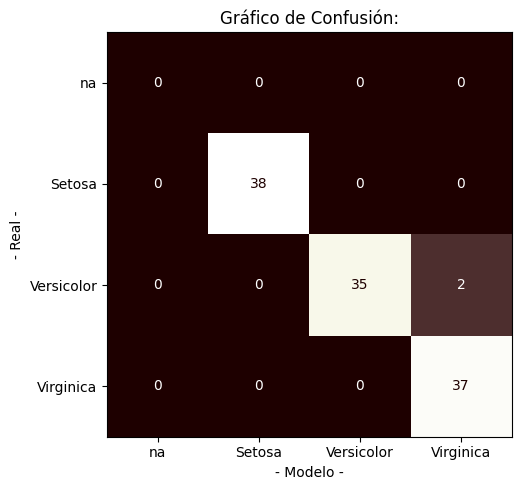

In [10]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) +' / M: ' + str(clPred)
        strTitulo = strTitulo + " [ " + ("OK" if (clPred==clReal) else "ERROR!") + " ]"

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, umbral_clasificacion/100.0, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
  Datos Entrada -> Clase Real / Clase Modelo [resultado]
  [5.7 2.5 5.  2. ]-> R: Virginica / M: Virginica [ OK ]
  [7.2 3.6 6.1 2.5]-> R: Virginica / M: Virginica [ OK ]
  [6.7 3.  5.  1.7]-> R: Versicolor / M: Versicolor [ OK ]
  [6.3 2.3 4.4 1.3]-> R: Versicolor / M: Versicolor [ OK ]
  [4.8 3.4 1.6 0.2]-> R: Setosa / M: Setosa [ OK ]
  [7.2 3.2 6.  1.8]-> R: Virginica / M: Virginica [ OK ]
  [4.9 2.4 3.3 1. ]-> R: Versicolor / M: Versicolor [ OK ]
  [5.8 2.8 5.1 2.4]-> R: Virginica / M: Virginica [ OK ]
  [4.3 3.  1.1 0.1]-> R: Setosa / M: Setosa [ OK ]
  [6.4 2.9 4.3 1.3]-> R: Versicolor / M: Versicolor [ OK ]
  [4.9 2.5 4.5 1.7]-> R: Virginica / M: Virginica [ OK ]
  [5.7 4.4 1.5 0.4]-> R: Setosa / M: Setosa [ OK ]
  [5.1 3.7 1.5 0.4]-> R: Setosa / M: Setosa [ OK ]
  [6.2 3.4 5.4 2.3]-> R: Virginica / M: Virginica [ OK ]
  [4.4 3.  1.3 0.2]-> R: Setosa / M: Setosa [ OK ]
  [5.6 2.7 4.2 1.3]-> R: Versicolor / M: Versicolor [ OK ]
  [5.9 3.2 4

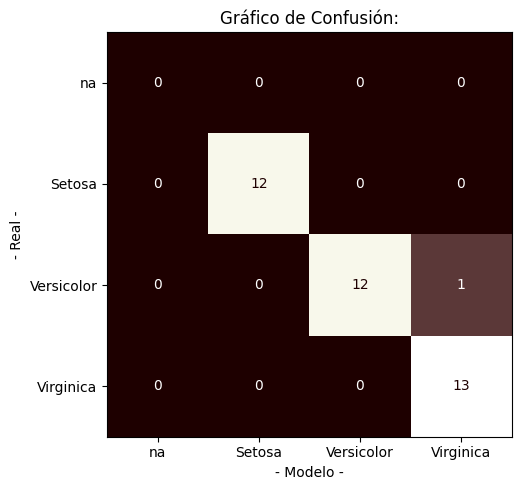

In [11]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, umbral_clasificacion/100.0, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [13]:
#@title Guardar Modelo entrenado

guardar_modelo = False #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/datosTFNE'  #@param {type:"string"}

if guardar_modelo:

    # guarda el modelo entrenado
    model.save(path_modelo)
    print("\n-Modelo guardado en ", path_modelo,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"
      import joblib
      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", fn_scaler,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo no guardado.
